@Author Samuel Lawson 983633


Code used to predict football match results of games in the EPL.

Libraries required: sklearn, numpy, matplotlib, tensorflow, pandas, pgmpy, scipy.

In [1]:
import logging, os, random, datetime, csv, warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
from IPython.display import display

#sklearn
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay,classification_report, accuracy_score, plot_confusion_matrix, accuracy_score

#tensorflow
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, Sequential, utils
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
import tensorflow.python.util.deprecation as deprecation

#warning supression
deprecation._PRINT_DEPRECATION_WARNINGS = False
warnings.filterwarnings("ignore")
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

#pgympy
from pgmpy.models import BayesianModel
from pgmpy.estimators import ParameterEstimator
from pgmpy.estimators import BayesianEstimator

#scipy
from scipy.stats import wilcoxon


Simply used to read a CSV file

In [2]:
class Read:
    def __init__(self,filename):
        self.reader = csv.reader(open(filename), delimiter = ",")
        self.data = list(self.reader)
        self.data.pop(0)

Represents all relevent information for a specific game

In [3]:
class Game:
    id = 0
    def __init__(self,data):
        Game.id += 1
        self.id = Game.id
        self.data = data
        index = 0
        for i in range(len(self.data)):
            try:
                self.data[i] = int(self.data[i])
            except:
                pass
        self.game_data = self.data[1:22]
        self.pregame_data = self.data[1:4]
        self.date = self.data[1]
        self.time = self.data[2]
        self.h_team = self.data[3]
        self.a_team = self.data[4]
        self.h_score = self.data[5]  
        self.a_score = self.data[6]
        if self.data[7] == "H":
            self.result = 0
        elif self.data[7] == "D":
            self.result = 1
        elif self.data[7] == "A":
            self.result = 2
        else:
            print("error")
        self.h_half_goals = self.data[8] #goals at half time
        self.a_half_goals = self.data[9] 
        self.half_result = self.data[10] 
        self.referee = self.data[11]
        self.h_shots = self.data[12]
        self.a_shots = self.data[13]
        self.h_shots_ontarg = self.data[14]
        self.a_shots_ontarg = self.data[15]
        self.h_fouls = self.data[16]
        self.a_fouls = self.data[17]
        self.h_corners = self.data[18]
        self.a_corners = self.data[19]
        self.h_yellow = self.data[20]
        self.a_yellow = self.data[21]
        self.h_red = self.data[22]
        self.a_red = self.data[23]

Represents all relevent data for a team

In [4]:
class Team:
    id = 0
    def __init__(self, name):
        Team.id += 1
        self.id = Team.id 
        self.name = name
        self.games = []
    
    def add_game(self,game):
        self.games.append(game)

    def get_id(self):
        return self.id
        
    def get_name(self):
        return self.name
    
    def get_games_before(self,game):
        games_before = []
        count = 0
        for i in self.games:
            if i == game:
                return self.games[:count]
            count+=1
        return []
    
    def get_stats(self,game_list):
        stats = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        game_count = 0
        smoother = 1
        if len(game_list) > 0:
            smoother = 0.1
        for i in game_list:
            if (i.h_team == self.name):
                game_count += 1
                #our home stats
                stats[1] = smoother*i.h_score+(1-smoother)*stats[1]
                stats[2] = smoother*i.h_half_goals+(1-smoother)*stats[2]
                stats[3] = smoother*i.h_shots+(1-smoother)*stats[3]
                stats[4] = smoother*i.h_shots_ontarg+(1-smoother)*stats[4]
                stats[5] = smoother*i.h_fouls+(1-smoother)*stats[5]
                stats[6] = smoother*i.h_corners+(1-smoother)*stats[6]
                stats[7] = smoother*i.h_yellow+(1-smoother)*stats[7]
                stats[8] = smoother*i.h_red+(1-smoother)*stats[8]
                #opps away stats
                stats[9] = smoother*i.a_score+(1-smoother)*stats[9]
                stats[10] = smoother*i.a_half_goals+(1-smoother)*stats[10]
                stats[11] = smoother*i.a_shots+(1-smoother)*stats[11]
                stats[12] = smoother*i.a_shots_ontarg+(1-smoother)*stats[12]
                stats[13] = smoother*i.a_fouls+(1-smoother)*stats[13]
                stats[14] = smoother*i.a_corners+(1-smoother)*stats[14]
                stats[15] = smoother*i.a_yellow+(1-smoother)*stats[15]
                stats[16] = smoother*i.a_red+(1-smoother)*stats[16]
                
            if (i.a_team == self.name):
                game_count += 1 
                #our away stats
                stats[1] = smoother*i.a_score+(1-smoother)*stats[1]
                stats[2] = smoother*i.a_half_goals+(1-smoother)*stats[2]
                stats[3] = smoother*i.a_shots+(1-smoother)*stats[3]
                stats[4] = smoother*i.a_shots_ontarg+(1-smoother)*stats[4]
                stats[5] = smoother*i.a_fouls+(1-smoother)*stats[5]
                stats[6] = smoother*i.a_corners+(1-smoother)*stats[6]
                stats[7] = smoother*i.a_yellow+(1-smoother)*stats[7]
                stats[8] = smoother*i.a_red+(1-smoother)*stats[8]
                #opp's home stats
                stats[9] = smoother*i.h_score+(1-smoother)*stats[9]
                stats[10] = smoother*i.h_half_goals+(1-smoother)*stats[10]
                stats[11] = smoother*i.h_shots+(1-smoother)*stats[11]
                stats[12] = smoother*i.h_shots_ontarg+(1-smoother)*stats[12]
                stats[13] = smoother*i.h_fouls+(1-smoother)*stats[13]
                stats[14] = smoother*i.h_corners+(1-smoother)*stats[14]
                stats[15] = smoother*i.h_yellow+(1-smoother)*stats[15]
                stats[16] = smoother*i.h_red+(1-smoother)*stats[16]
        
        count = 0
        stats[0] = self.id;
        for j in range(1,len(stats)):
            count += 1
            if game_count !=0:
                stats[j] = round((stats[j]),2)
            else:
                stats = False
        return stats
  
    def get_stats_before(self,game):
        game_list = self.get_games_before(game)
        stats = self.get_stats(game_list)
        return stats
    

Reads the CSV file and creates a team for each team and a game for each game. These are stored in the teams and games lists. 

Also creates the labels and data that will be used to test and train the models.

In [5]:
read = Read("Data/19_20_data.csv")

games = list()
teams = list()
data = []
index = 0
labels = []
data1d = []
scores = []

for result in read.data:
    
    games.append(Game(result))
    found = False
    for i in teams:
        if i.get_name() == result[3]:
            found = True
            break
    if (found == False):
        teams.append(Team(result[3]))
    found = False
    
for team in teams:
    for game in games:
        if game.h_team == team.name or game.a_team == team.name:
            team.add_game(game)
for game in games:
    data.append([[],[]])
    data1d.append([])
    res = np.array(game.result)
    labels.append(res)
    scores.append([game.h_score,game.a_score])
    for team in teams:
        if game.h_team == team.name:
            if team.get_stats_before(game):
                for i in team.get_stats_before(game):
                    data[index][0].append(i)
                    data1d[index].append(i)
    for team in teams:
        if game.a_team == team.name:
            if team.get_stats_before(game):
                for i in team.get_stats_before(game):
                    data[index][1].append(i)
                    data1d[index].append(i)
    index+=1

data1d = data1d[10:]
data = data[10:]
labels = labels[10:]
scores = scores[10:]
        
np_scores = np.array(scores)
np_labels = np.array(labels)
np_data = np.array(data)

Constructs and returns Neural Network trained using the data and labels parameters.

In [6]:
def build_model(data,labels):
    model = Sequential()
    model.add(Flatten())
    
    model.add(Dense(32, activation='relu', input_shape=train_data[0].shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='adam',
                  loss="sparse_categorical_crossentropy",
                  metrics = "accuracy")
    
    model_history = model.fit(data, labels, epochs=200, verbose = 0)
    
    return(model)

Evaluates the accuracy of the a Neural Network and produces a confusion matrix.

In [7]:
def evaluate_model(model,data,labels):
    model.evaluate(data,labels)
    model_pred = model.predict_classes(data)
    
    model_matrix = confusion_matrix(labels, model_pred)
    model_show = ConfusionMatrixDisplay(confusion_matrix = model_matrix)
    model_show = model_show.plot(cmap=plt.cm.Oranges)
    m = tf.keras.metrics.Accuracy()
    m.update_state(labels, model_pred)
    return(m.result().numpy())

Randomly selects a result and evaluates the prediction, also produces a confusion matrix.

In [8]:
def random_guess(test_labels):
    rand_labels = []
    for i in test_labels:
        rand = random.randint(0,2)
        rand_labels.append(rand)
    rand_labels = np.array(rand_labels)
    rand_matrix = confusion_matrix(test_labels, rand_labels)
    rand_show = ConfusionMatrixDisplay(confusion_matrix = rand_matrix)
    
    rand_show = rand_show.plot(cmap=plt.cm.Greys)
    g = tf.keras.metrics.Accuracy()
    g.update_state(test_labels, rand_labels)
    return(g.result().numpy())

Builds a bayesian network using the input parameters and results the network.

In [9]:
#baysian network

def build_baysian(bays_data, bays_scores, bays_labels):
    
    size = len(bays_data)
    home_score_avg = []
    away_score_avg = []
    home_conceded_avg = []
    away_conceded_avg = []
    home_shots_on_avg = []
    away_shots_on_avg = []
    home_shots_on_conceded_avg = []
    away_shots_on_conceded_avg = []
    home_shots_avg = []
    away_shots_avg = []
    home_shots_conceded_avg = []
    away_shots_conceded_avg = []
    score_dif = []
    conc_dif = []
    a_score = []
    h_score = []
    results = []
    count = 0

    while True:
        home_score_avg.append(round(bays_data[count][0][1],0))
        away_score_avg.append(round(bays_data[count][1][1],0))
        home_conceded_avg.append(round(bays_data[count][0][9],0))
        away_conceded_avg.append(round(bays_data[count][1][9],0))
        home_shots_on_avg.append(round(bays_data[count][0][4],0))
        away_shots_on_avg.append(round(bays_data[count][1][4],0))
        home_shots_on_conceded_avg.append(round(bays_data[count][0][12],0))
        away_shots_on_conceded_avg.append(round(bays_data[count][1][12],0))
        home_shots_avg.append(round(bays_data[count][0][3],0))
        away_shots_avg.append(round(bays_data[count][1][3],0))
        home_shots_conceded_avg.append(round(bays_data[count][0][11],0))
        away_shots_conceded_avg.append(round(bays_data[count][1][11],0))

        h_score.append(bays_scores[count][0])
        a_score.append(bays_scores[count][1])
        results.append(int(bays_labels[count]))
        if count >= size-10:
            break
        count +=1

    datas = pd.DataFrame(data={'home': home_score_avg, 
                               'away': away_score_avg,
                               'home_conc': home_conceded_avg,
                               'away_conc': away_conceded_avg,
                               'home_shots_on': home_shots_on_avg,
                               'away_shots_on': away_shots_on_avg,
                               'home_shots_on_conc': home_shots_on_conceded_avg,
                               'away_shots_on_conc': away_shots_on_conceded_avg,
                               'home_shots': home_shots_avg,
                               'away_shots': away_shots_avg,
                               'home_shots_conc': home_shots_conceded_avg,
                               'away_shots_conc': away_shots_conceded_avg,
                               'h_score':h_score,
                               'a_score':a_score,
                               'result': results
                              })

    network =  BayesianModel([('h_score','result'),('a_score','result'),('home', 'h_score'), ('away', 'a_score'), ('home_conc', 'a_score'), ('away_conc', 'h_score'), 
                              ('home_shots', 'home_shots_on'),('away_shots', 'away_shots_on'), ('home_shots_conc', 'home_shots_on_conc'),
                              ('away_shots_conc', 'away_shots_on_conc'), ('home_shots_on', 'home'), ('away_shots_on', 'away'),
                              ('away_shots_on_conc', 'away_conc'),('home_shots_on_conc', 'home_conc')])


    network.fit(datas, estimator=BayesianEstimator)
    return network

Predicts the most likely winner of a game based on the match parameter using a pregenerated Bayesian Network.

In [10]:
def bays_predict(match,network):
    a = (round(match[0][1],0))
    b = (round(match[1][1],0))        
    c = (round(match[0][9],0))
    d = (round(match[1][9],0))
    e = (round(match[0][4],0))
    f = (round(match[1][4],0))
    g = (round(match[0][12],0))
    h = (round(match[1][12],0))
    i = (round(match[0][3],0))
    j = (round(match[1][3],0))
    k = (round(match[0][11],0))
    l = (round(match[1][11],0))
    test = pd.DataFrame(data={'home': [a],
                              'away': [b],
                              'home_conc': [c],
                              'away_conc': [d],
                              'home_shots_on': [e],
                              'away_shots_on': [f],
                              'home_shots_on_conc': [g],
                              'away_shots_on_conc': [h],
                              'home_shots': [i],
                              'away_shots': [j],
                              'home_shots_conc': [k],
                              'away_shots_conc': [l]
                              })
    prediction = 0
    try: #possibility of unusually high result e.g a team averages 6 goals per game near the start of the season
        res = network.predict_probability(test)
    
        max_prob = res['result_0'][0]

        if res['result_1'][0] > max_prob:
            max_prob = res['result_1'][0]
            prediction = 1
        if res['result_2'][0] > max_prob:
            max_prob = res['result_2'][0]
            prediction = 2
    except:
        pass
    return prediction

Evaluated the Bayesian Network's predictions and produces a confusion matrix.

In [11]:
def evaluate_baysian(network ,data, test_labels):
    results = []
    for i in range(len(test_labels)):
        prediction = bays_predict(data[i],network)
        results.append(prediction)
    results = np.array(results)
    model_matrix = confusion_matrix(test_labels, results)
    model_show = ConfusionMatrixDisplay(confusion_matrix = model_matrix)
    model_show = model_show.plot(cmap=plt.cm.Greens)
    r = tf.keras.metrics.Accuracy()
    r.update_state(test_labels, results)
    return(r.result().numpy())


Conducts k-fold cross validation 20 time and works out each models average accuracy for each run and uses this to create an overall average accuracy for each model.

3/3 [==============================] - 0s 667us/step - loss: 1.0718 - accuracy: 0.4595
rand:
0.32662162
[0.35135135, 0.2945946, 0.30810812, 0.3054054, 0.32162163, 0.3837838, 0.34324324, 0.33243242, 0.3108108, 0.34324324, 0.2918919, 0.31621623, 0.3081081, 0.27297297, 0.2891892, 0.36486486, 0.34864864, 0.3162162, 0.34054053, 0.38918918]
nn:
0.4814865
[0.4783784, 0.5081081, 0.48108107, 0.46216217, 0.4810811, 0.47567567, 0.48108107, 0.4783784, 0.4783784, 0.5081081, 0.4945946, 0.44864863, 0.4864865, 0.48378378, 0.45945945, 0.4864865, 0.47027028, 0.5, 0.48378378, 0.48378378]
bn:
0.46702704
[0.45675677, 0.47297296, 0.46216217, 0.44864863, 0.46486488, 0.45675674, 0.47027028, 0.47027028, 0.46216217, 0.48108107, 0.46756756, 0.48378378, 0.46486488, 0.45675674, 0.46756756, 0.4783784, 0.47567567, 0.45135134, 0.47837836, 0.47027028]


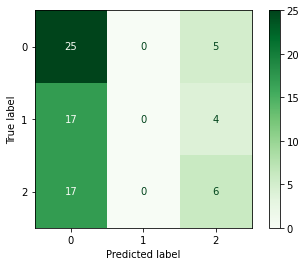

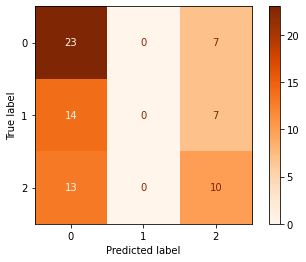

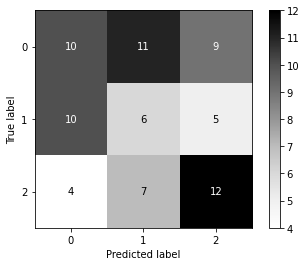

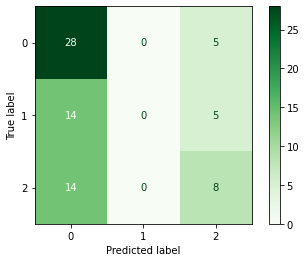

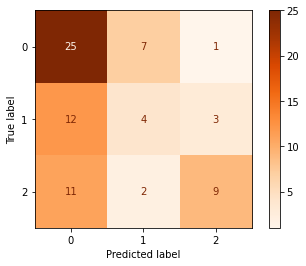

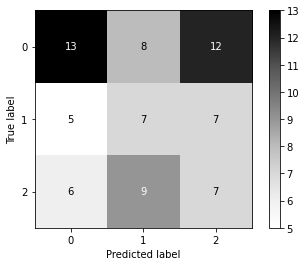

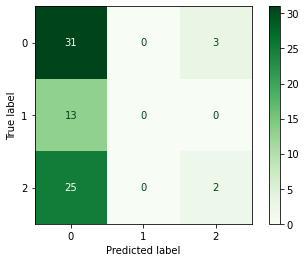

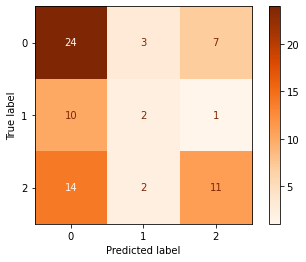

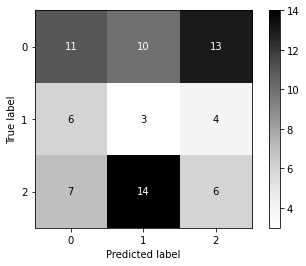

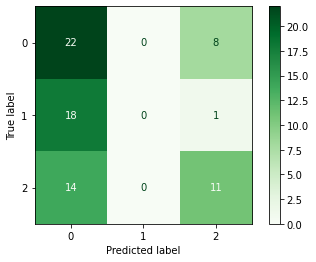

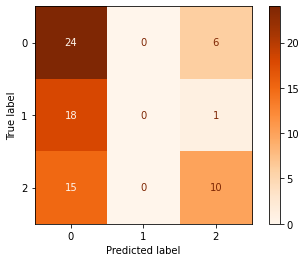

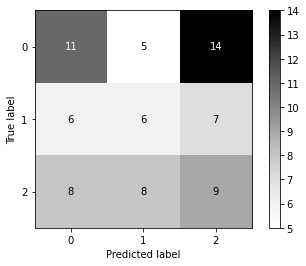

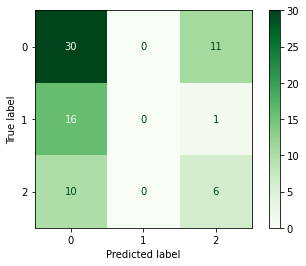

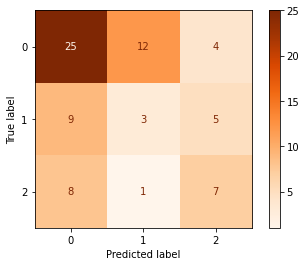

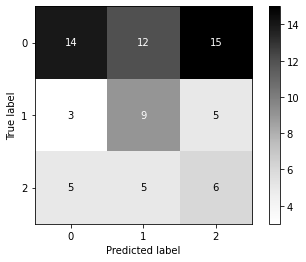

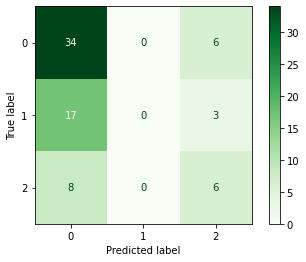

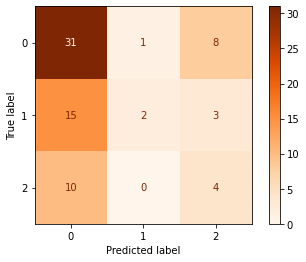

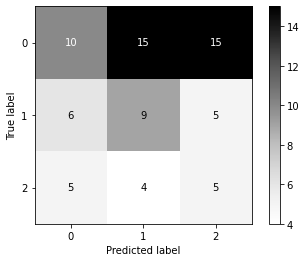

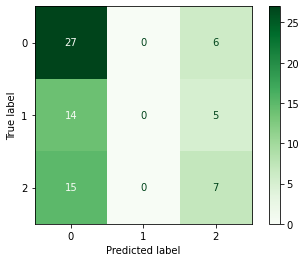

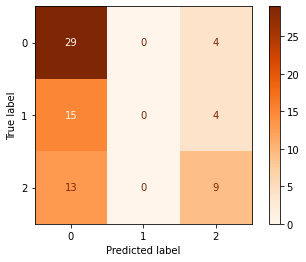

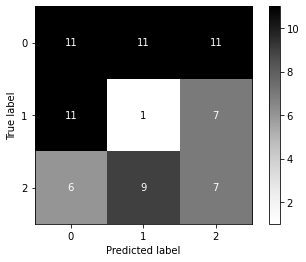

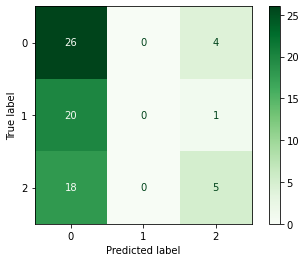

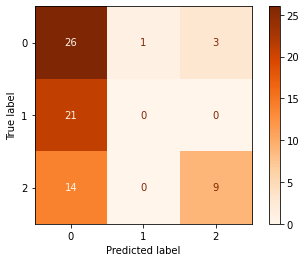

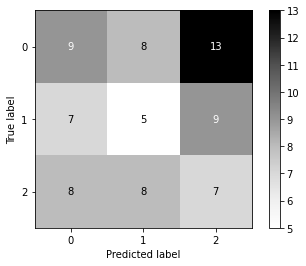

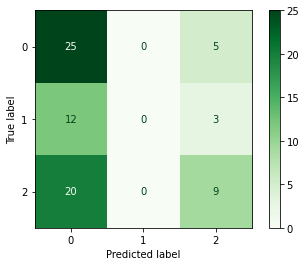

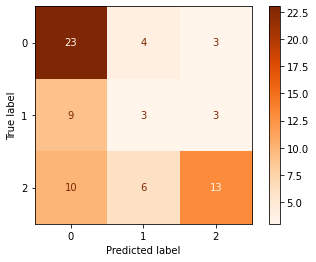

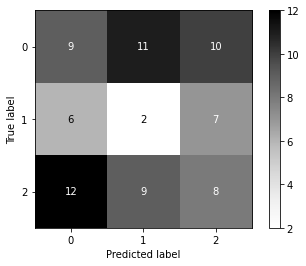

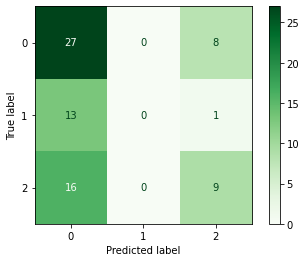

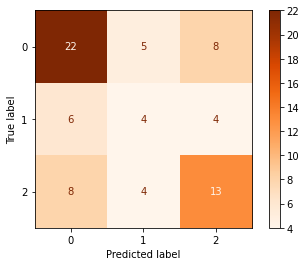

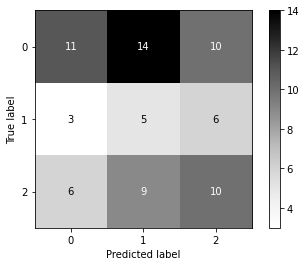

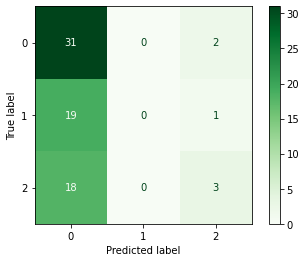

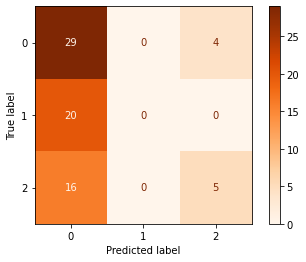

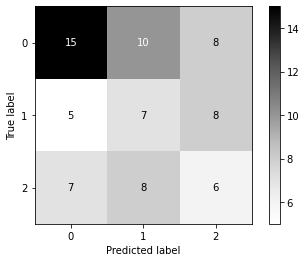

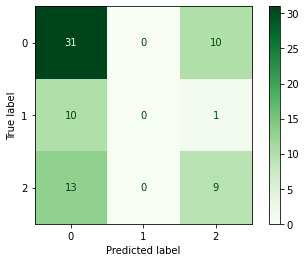

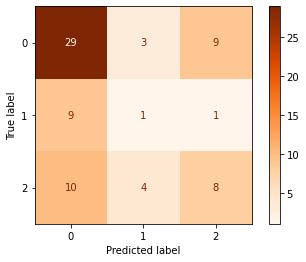

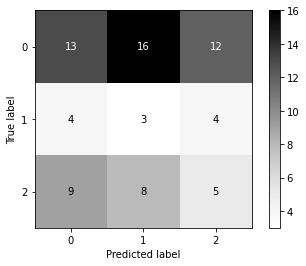

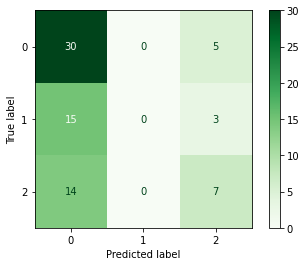

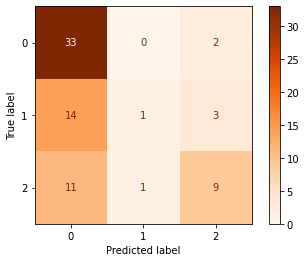

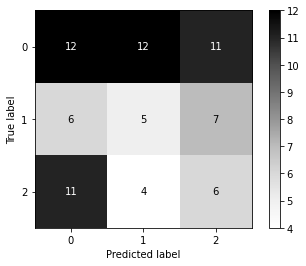

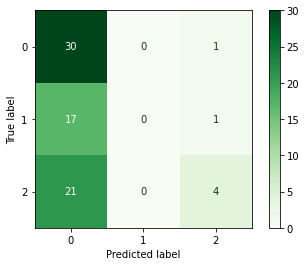

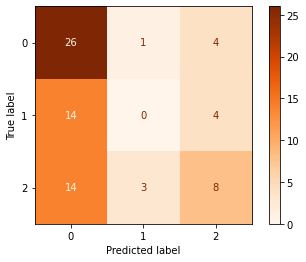

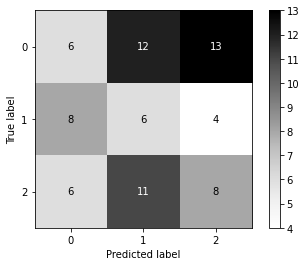

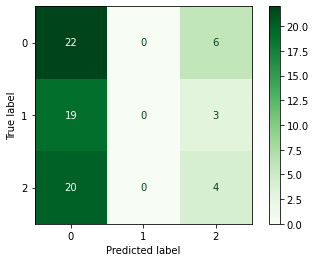

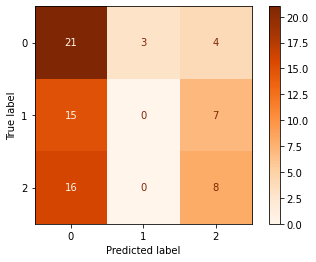

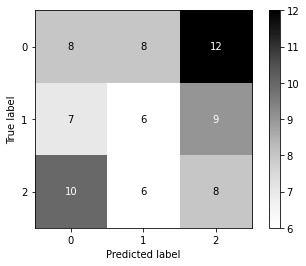

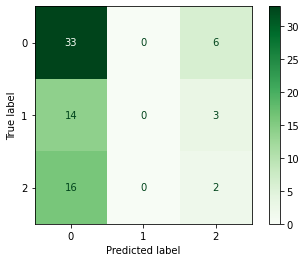

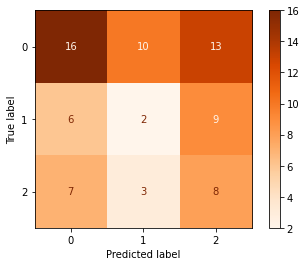

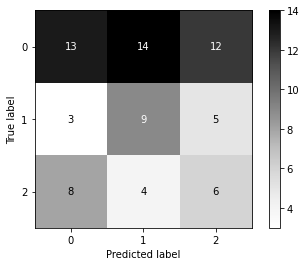

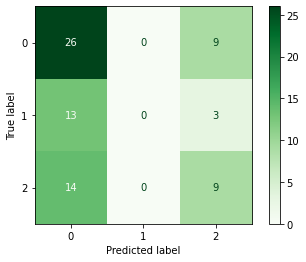

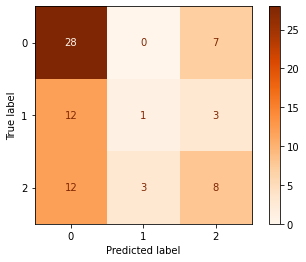

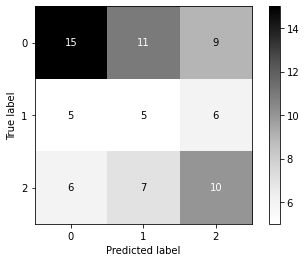

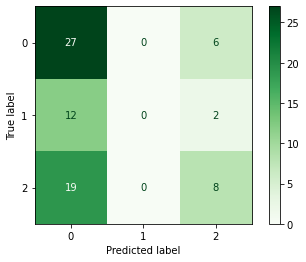

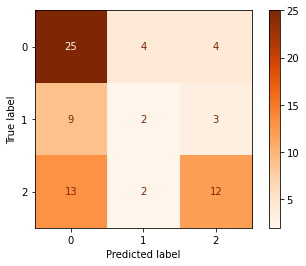

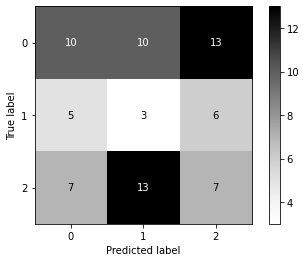

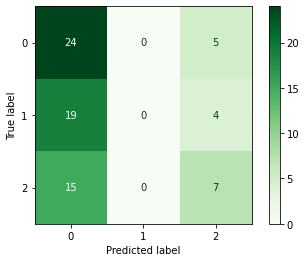

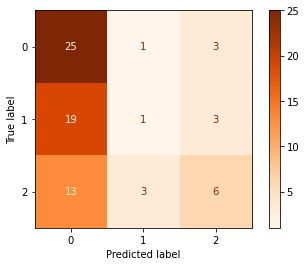

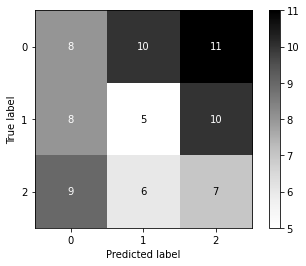

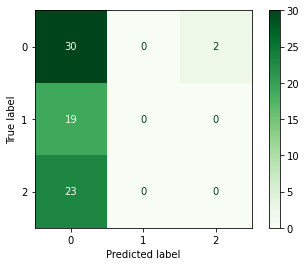

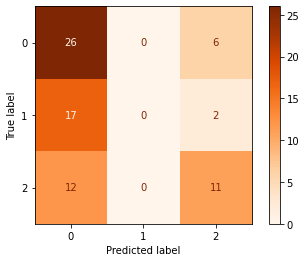

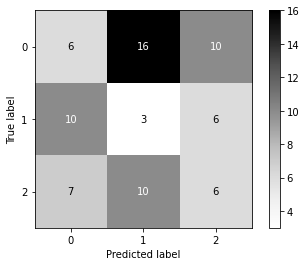

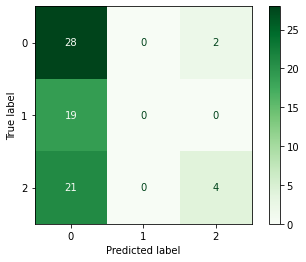

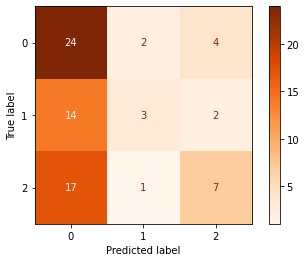

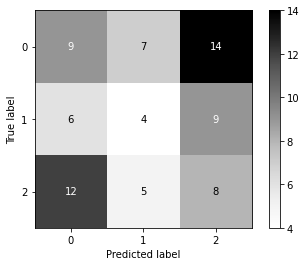

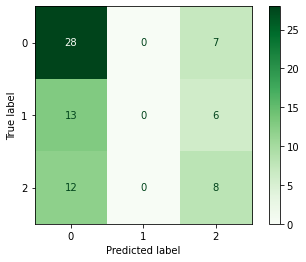

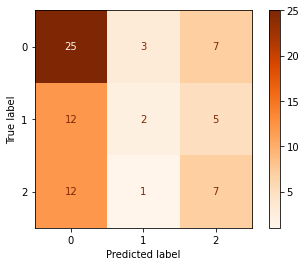

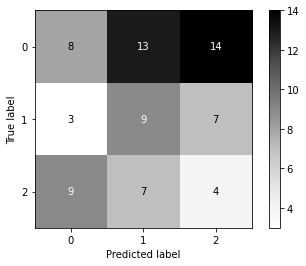

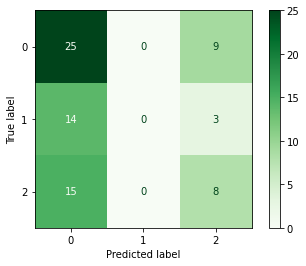

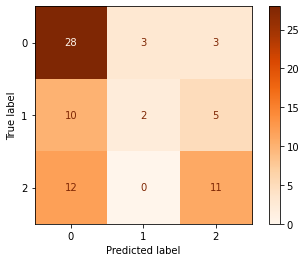

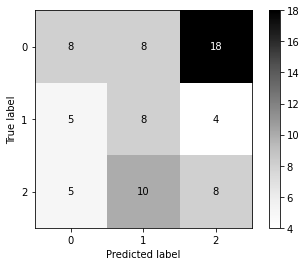

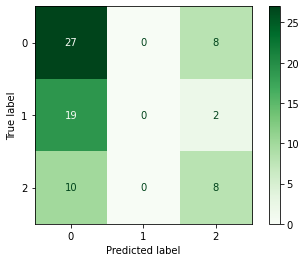

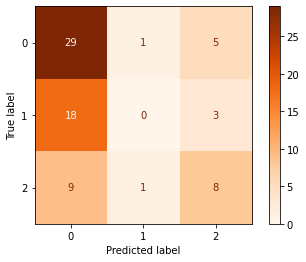

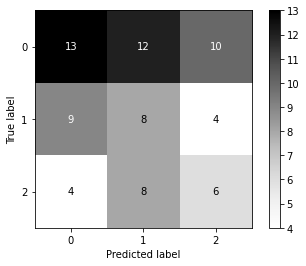

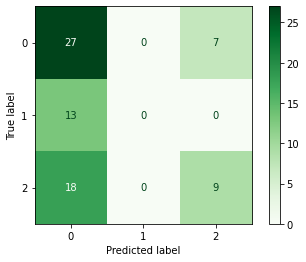

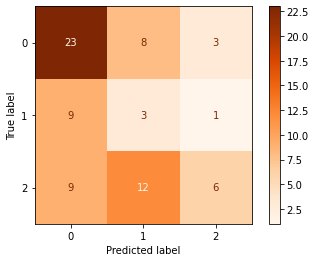

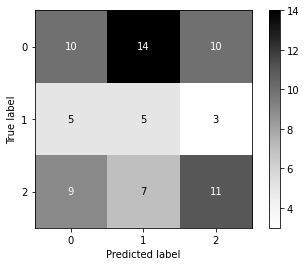

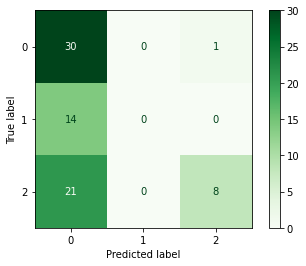

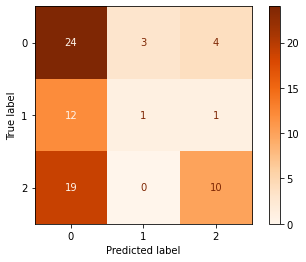

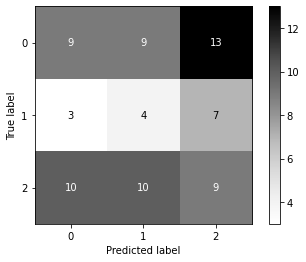

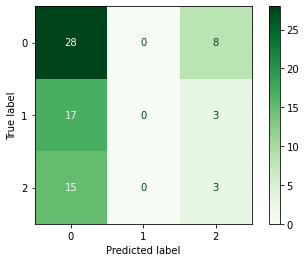

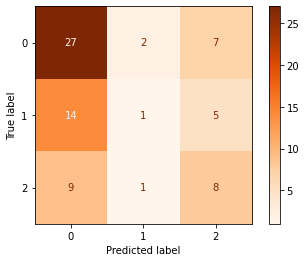

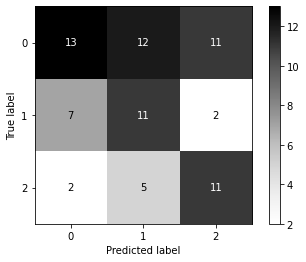

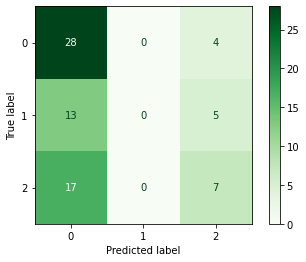

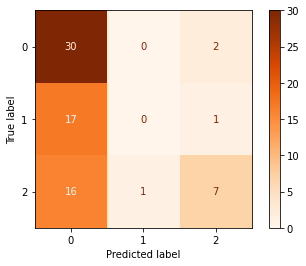

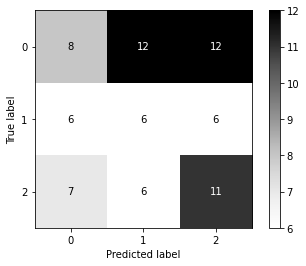

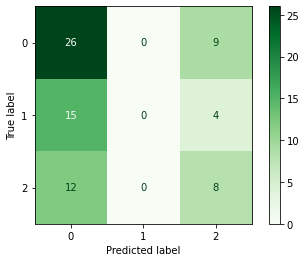

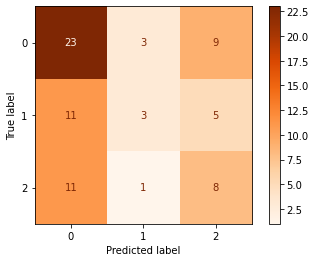

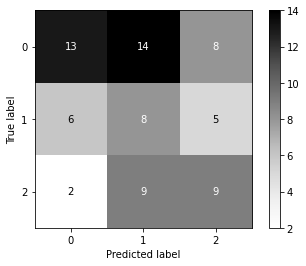

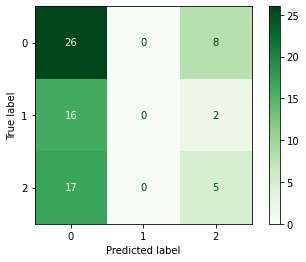

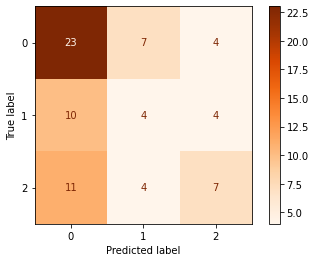

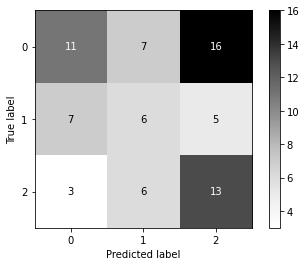

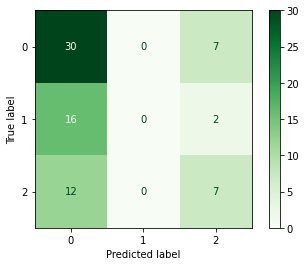

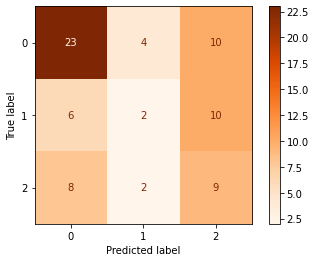

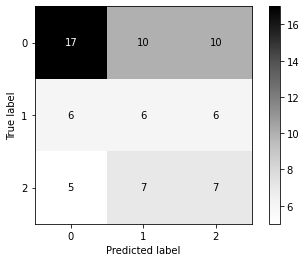

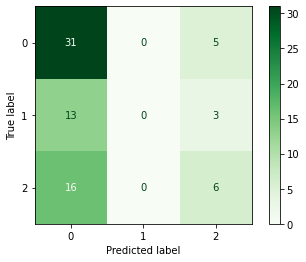

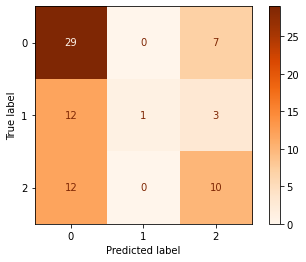

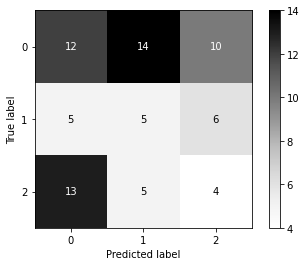

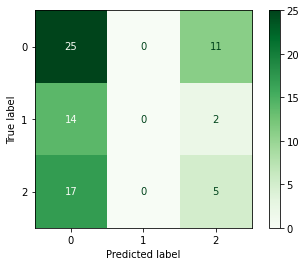

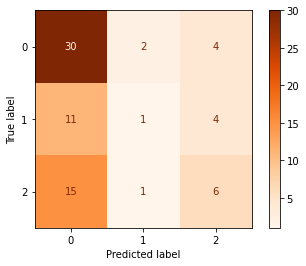

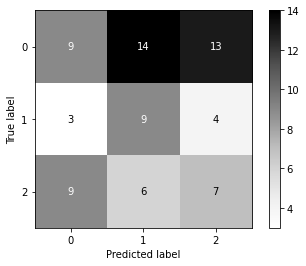

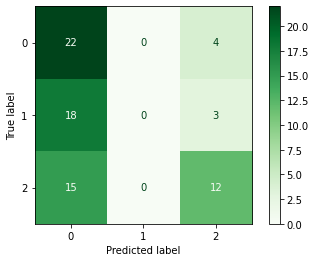

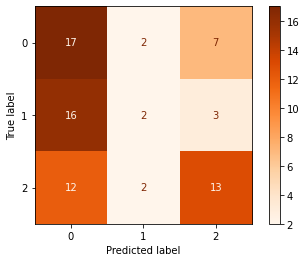

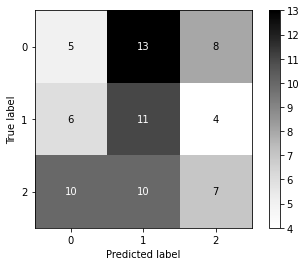

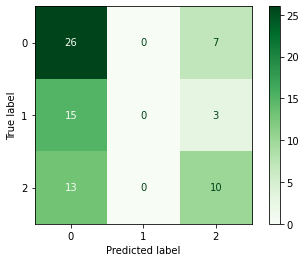

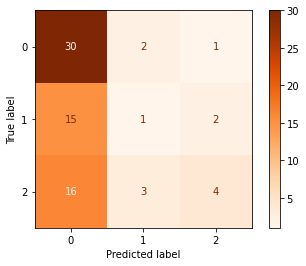

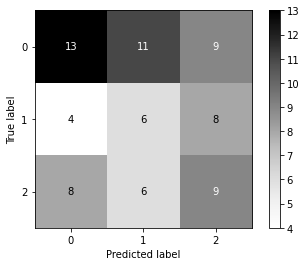

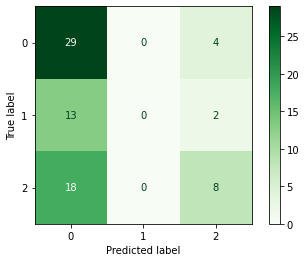

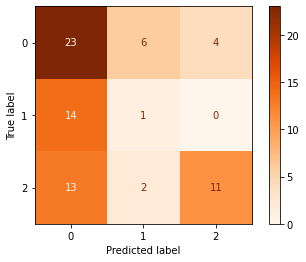

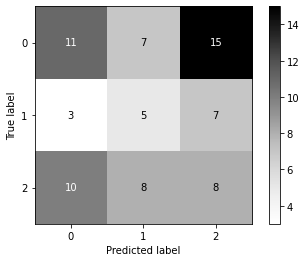

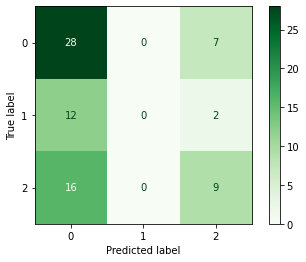

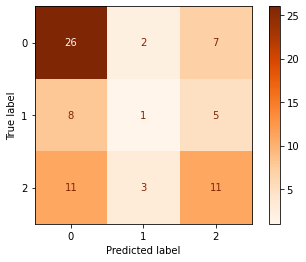

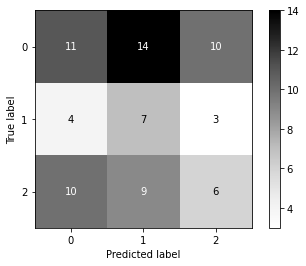

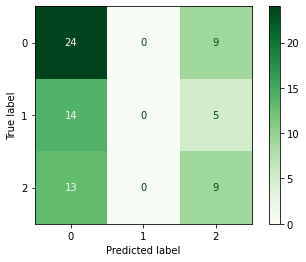

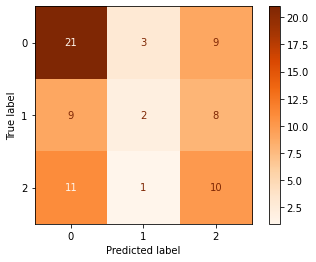

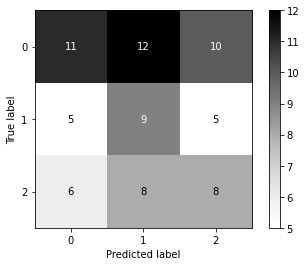

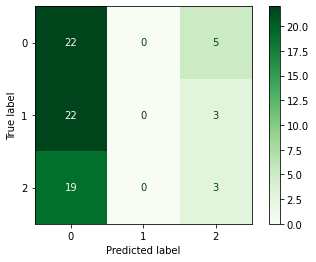

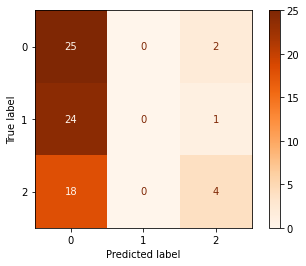

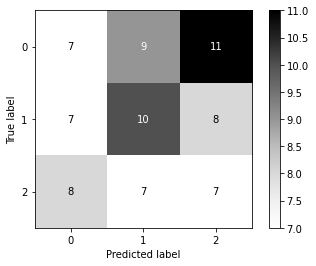

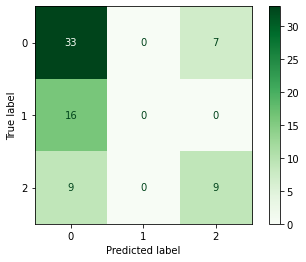

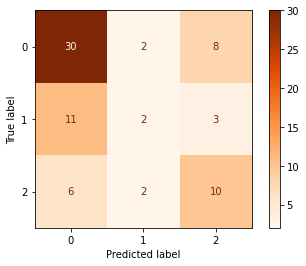

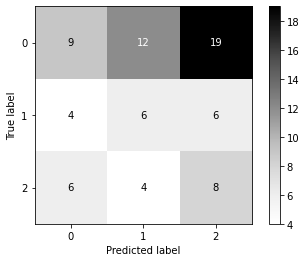

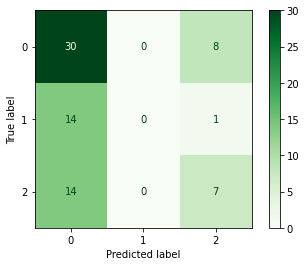

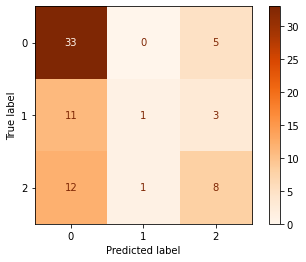

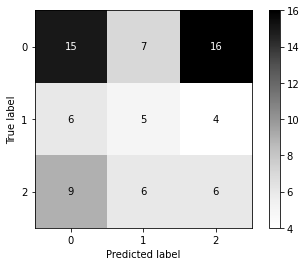

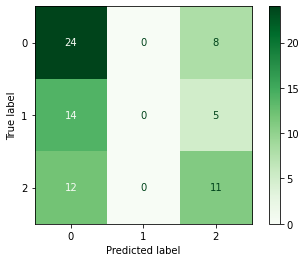

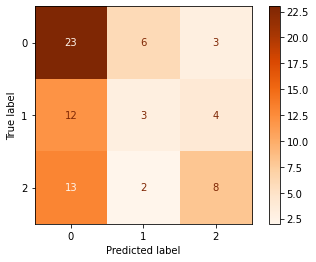

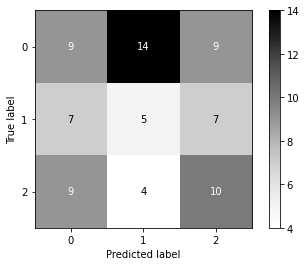

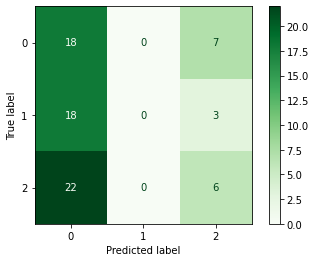

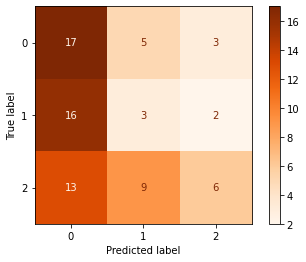

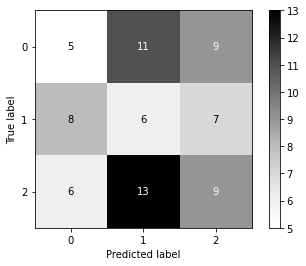

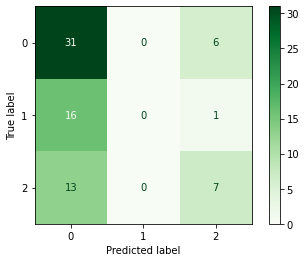

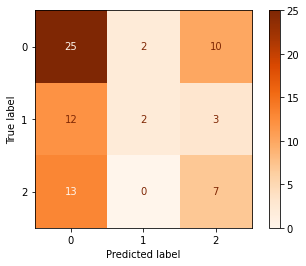

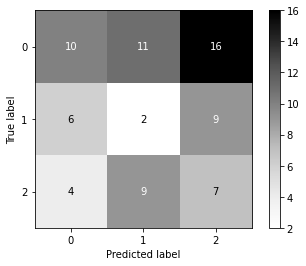

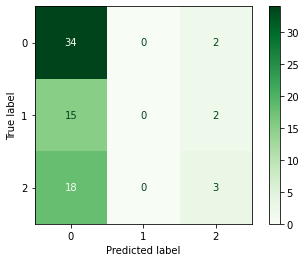

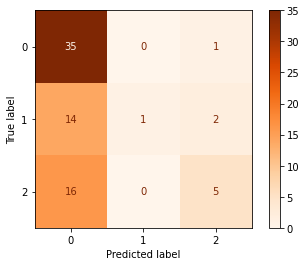

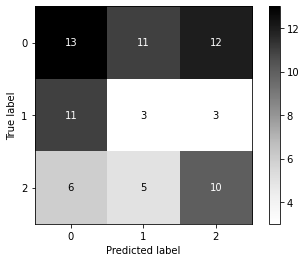

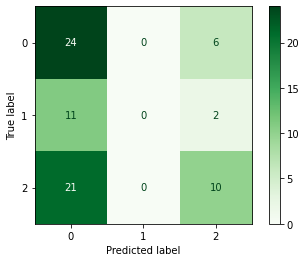

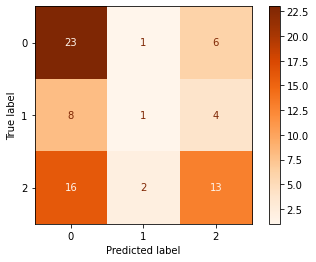

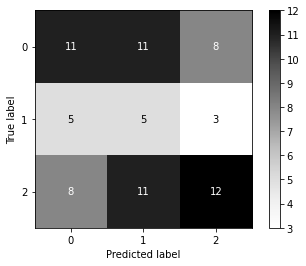

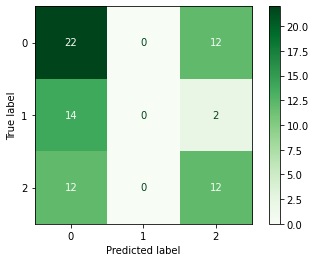

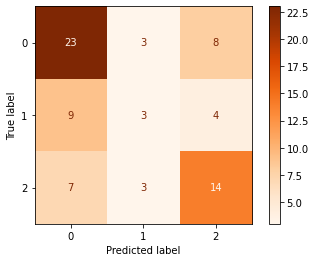

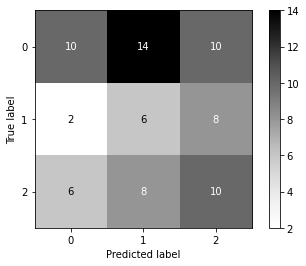

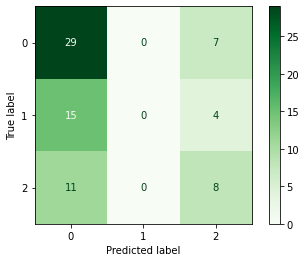

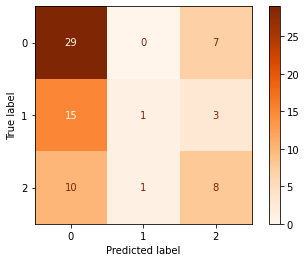

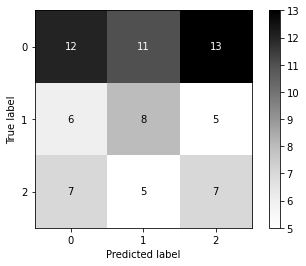

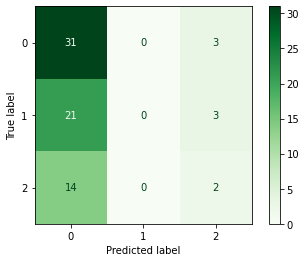

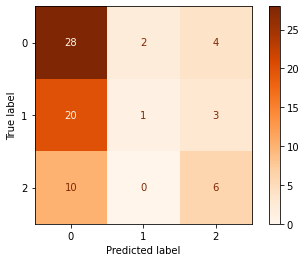

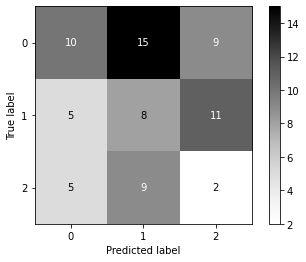

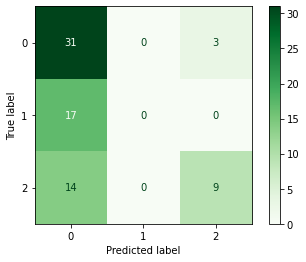

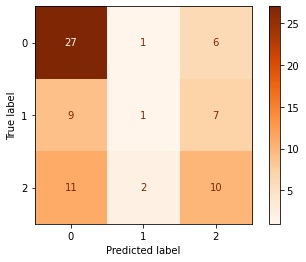

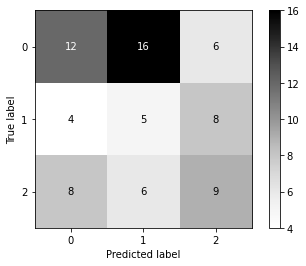

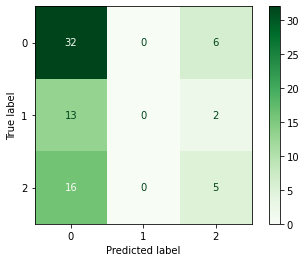

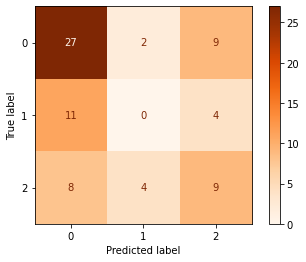

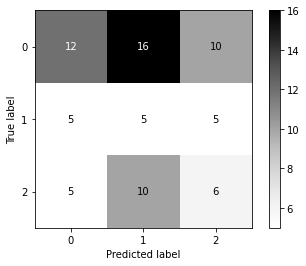

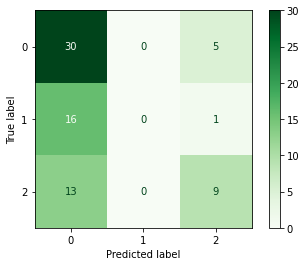

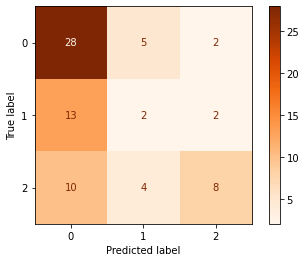

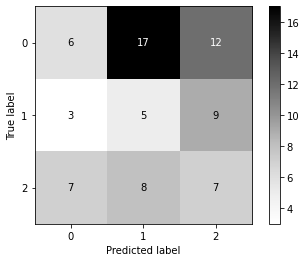

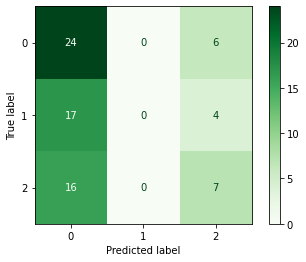

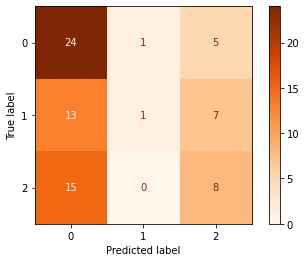

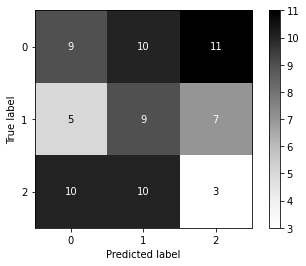

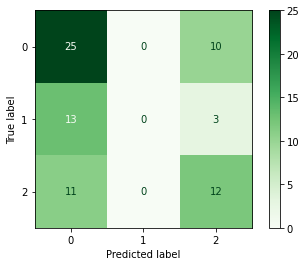

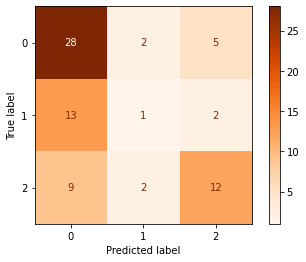

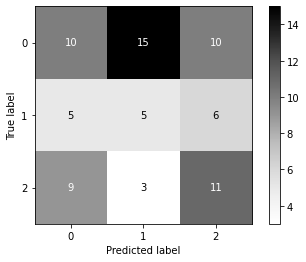

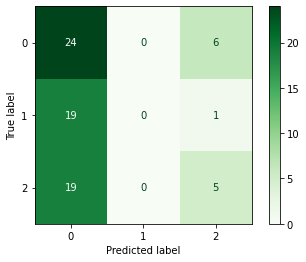

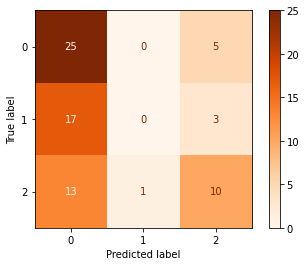

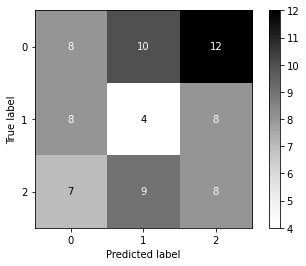

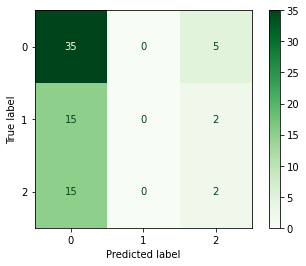

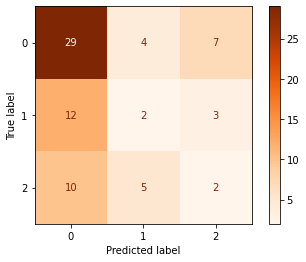

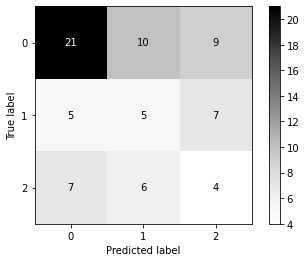

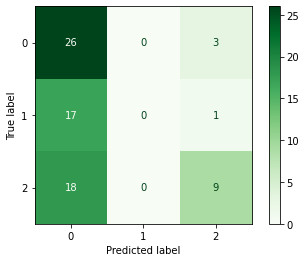

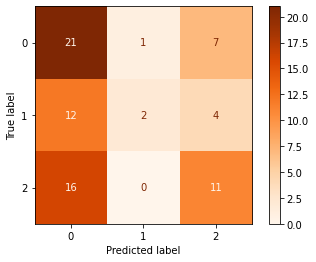

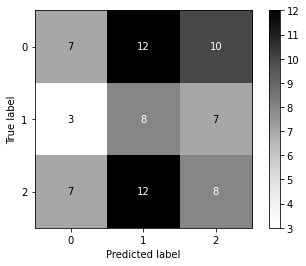

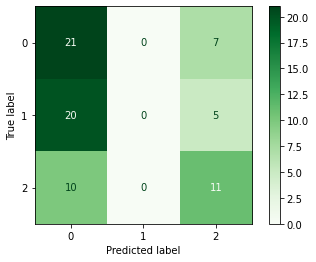

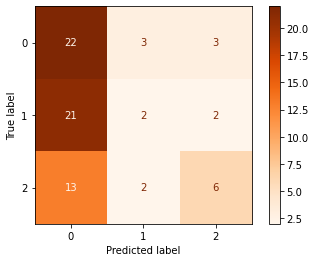

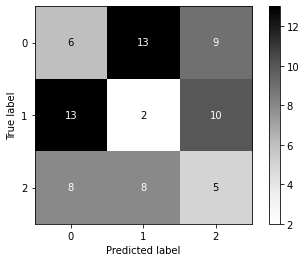

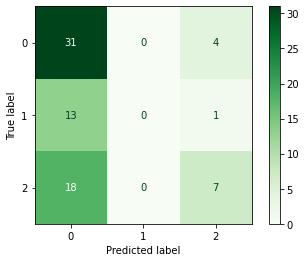

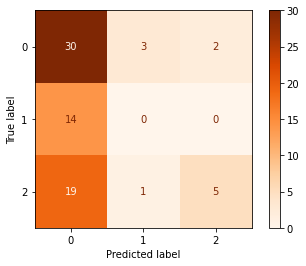

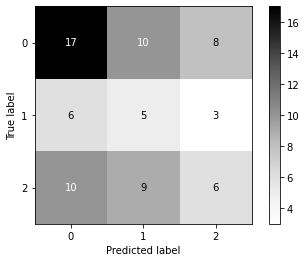

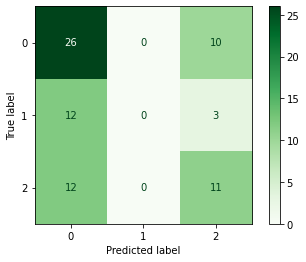

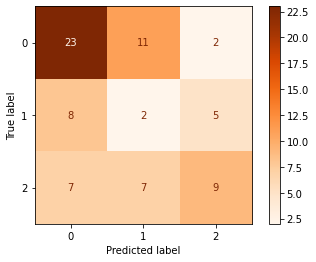

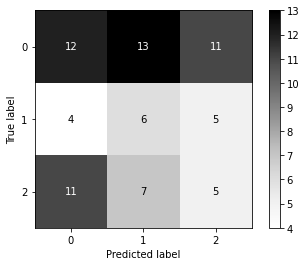

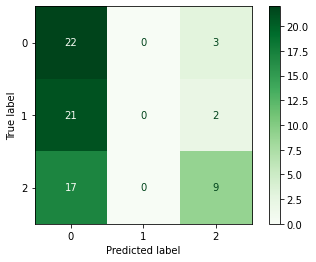

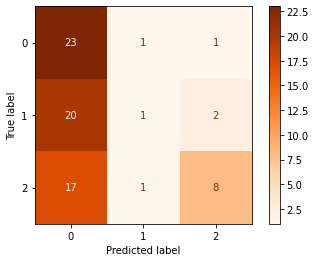

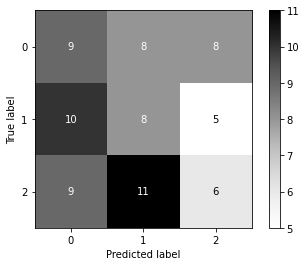

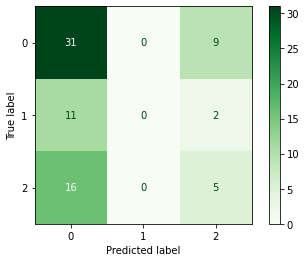

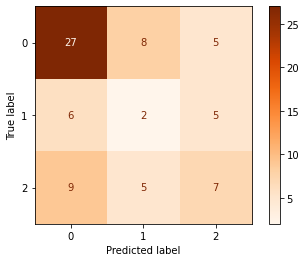

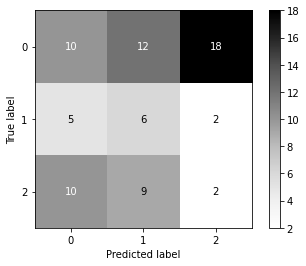

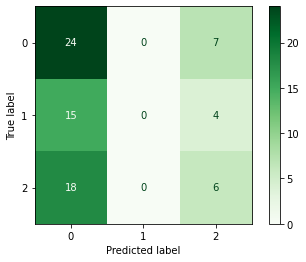

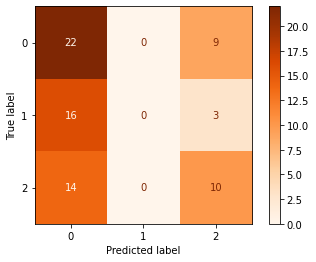

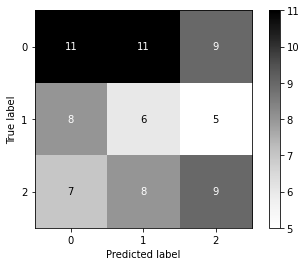

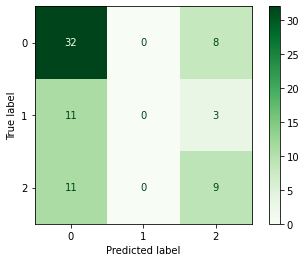

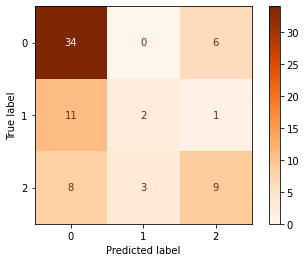

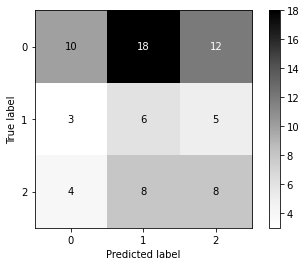

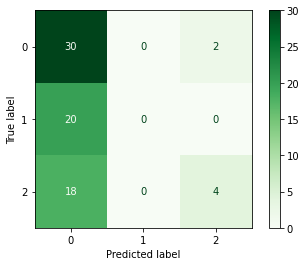

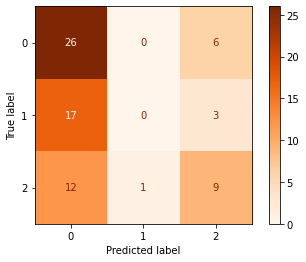

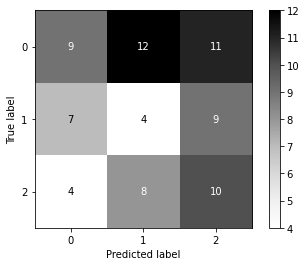

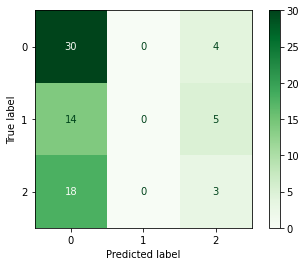

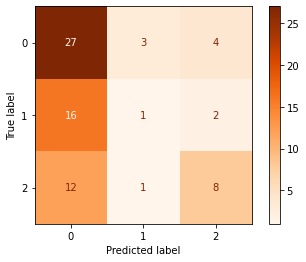

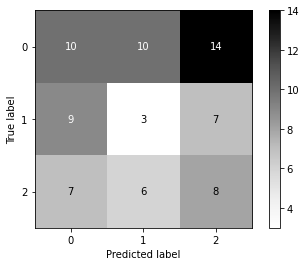

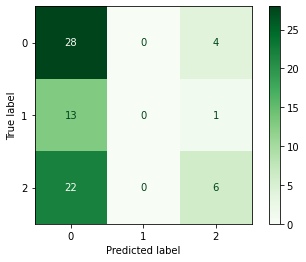

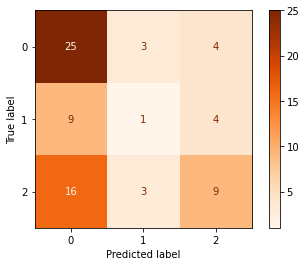

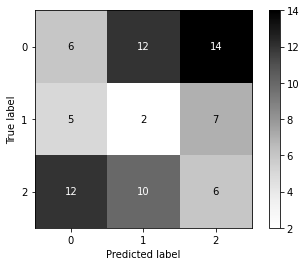

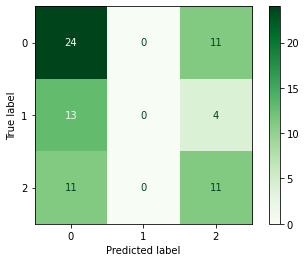

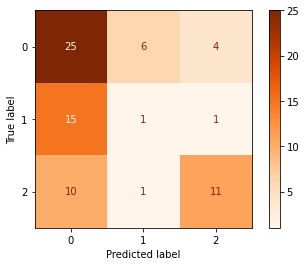

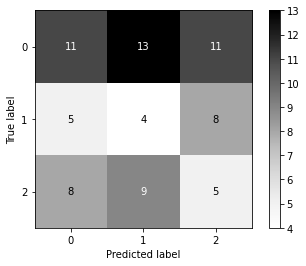

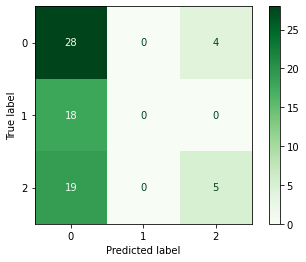

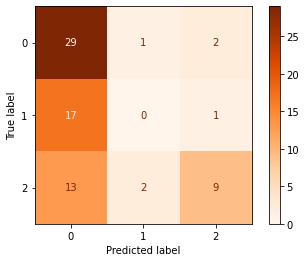

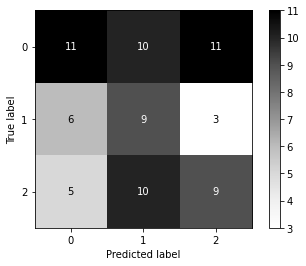

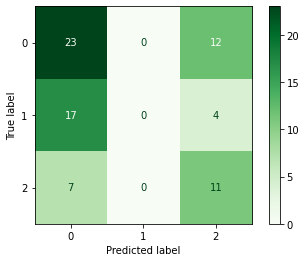

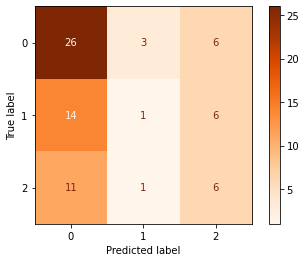

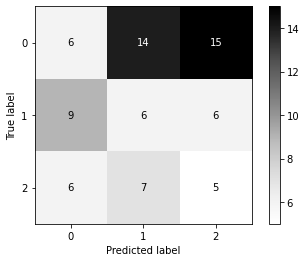

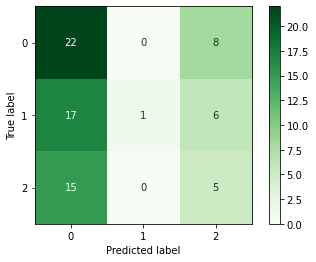

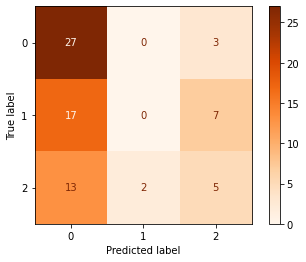

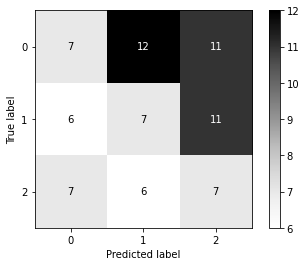

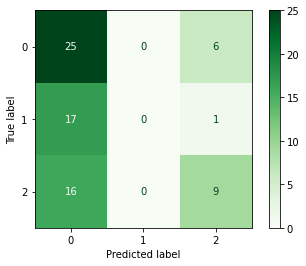

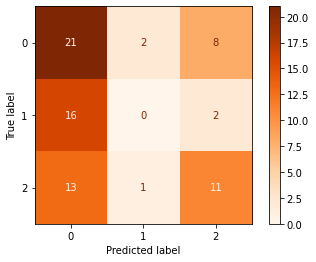

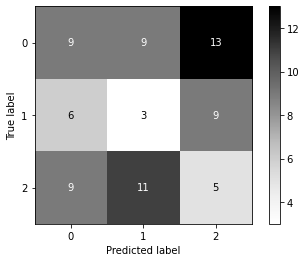

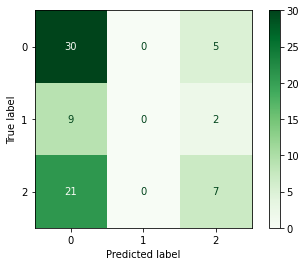

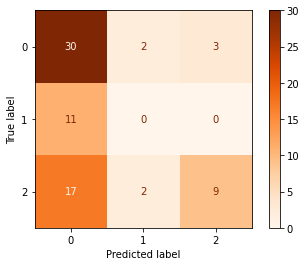

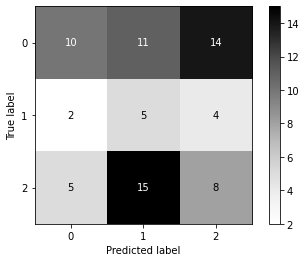

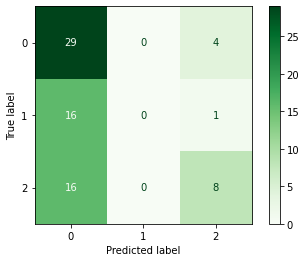

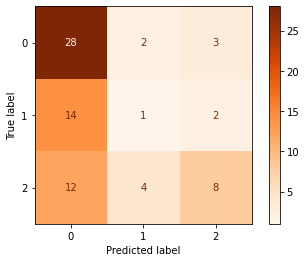

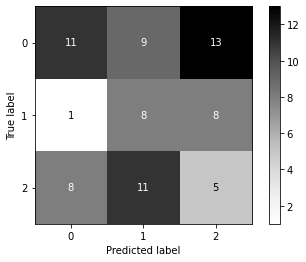

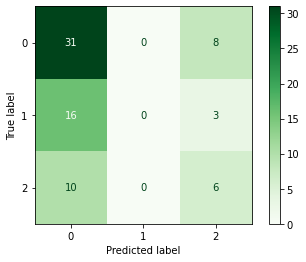

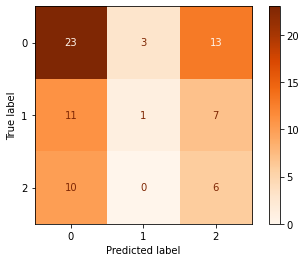

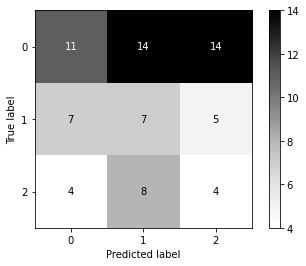

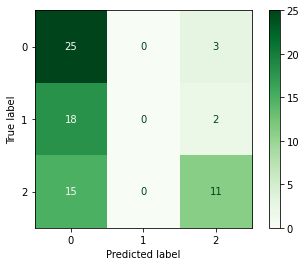

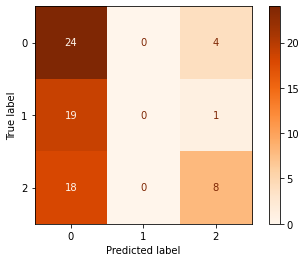

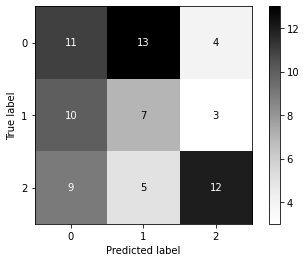

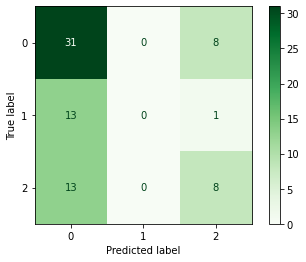

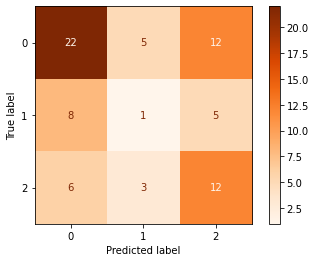

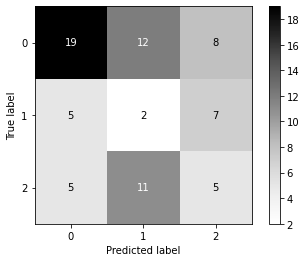

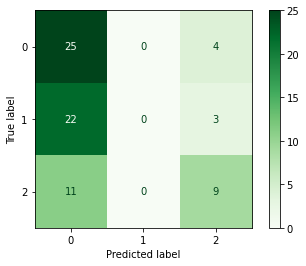

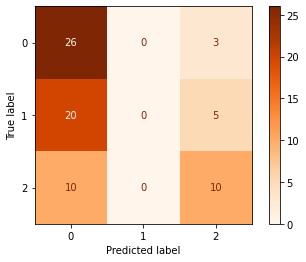

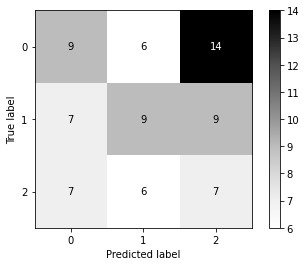

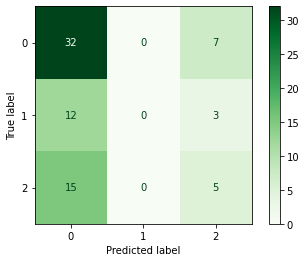

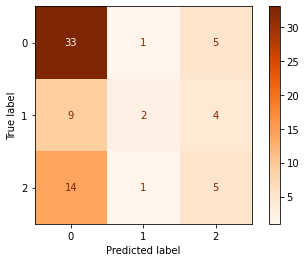

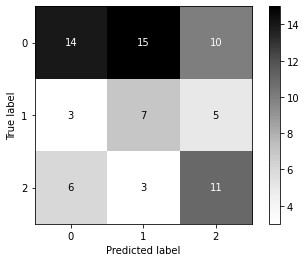

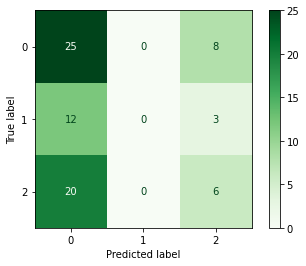

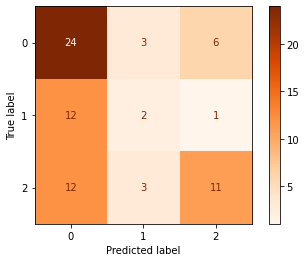

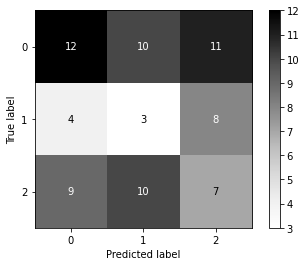

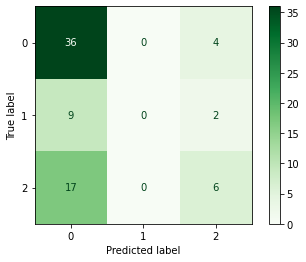

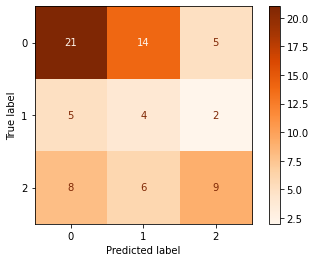

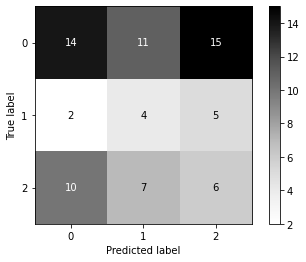

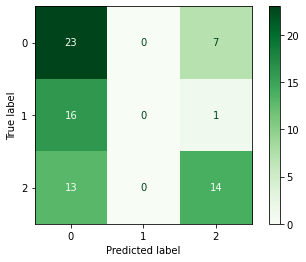

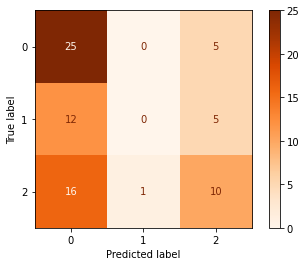

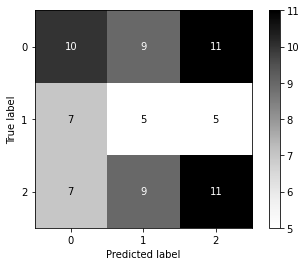

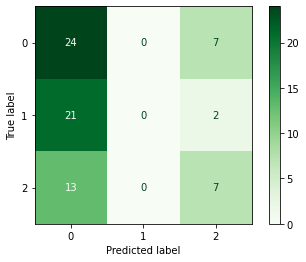

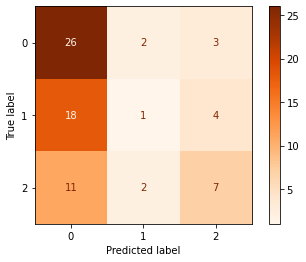

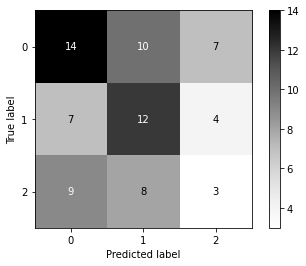

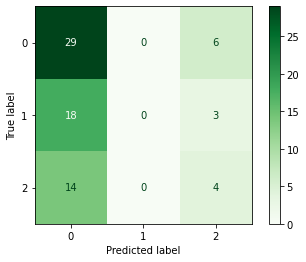

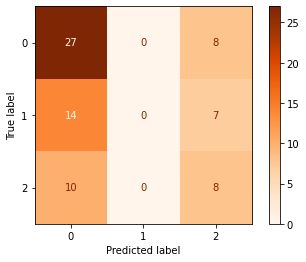

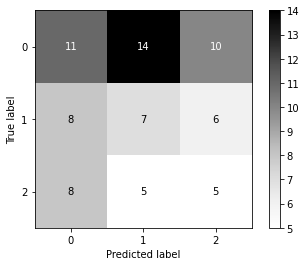

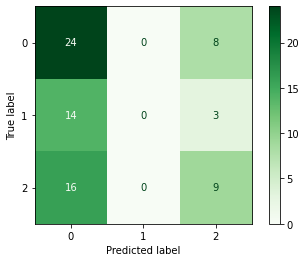

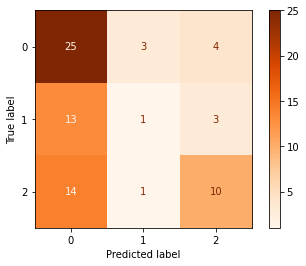

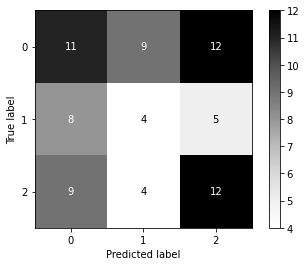

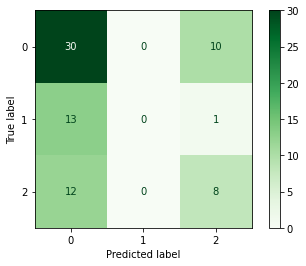

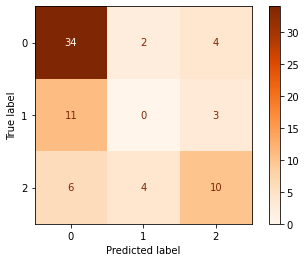

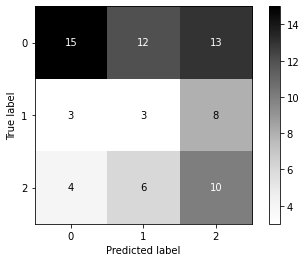

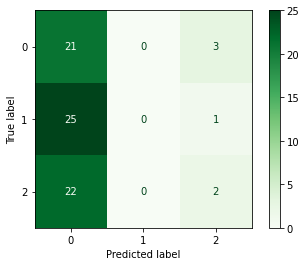

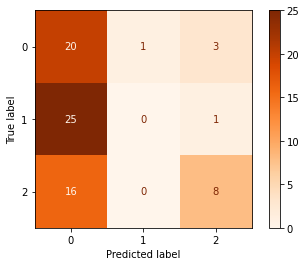

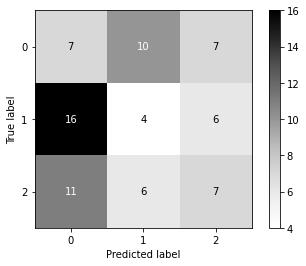

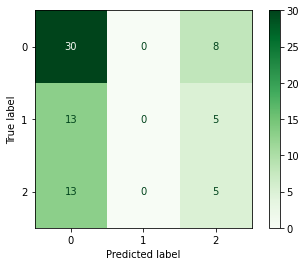

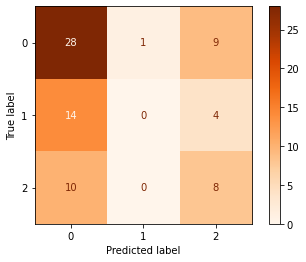

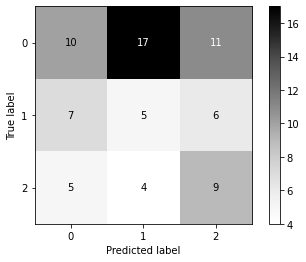

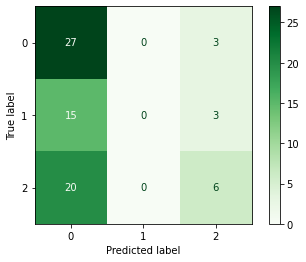

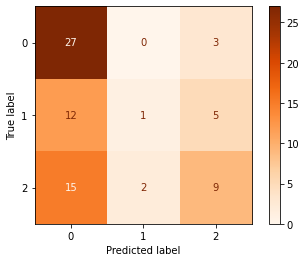

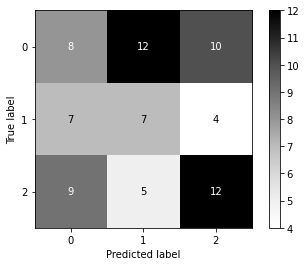

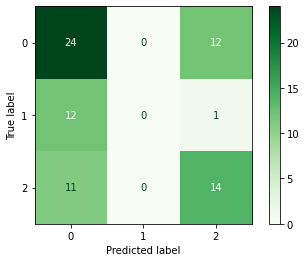

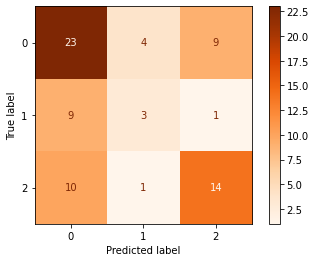

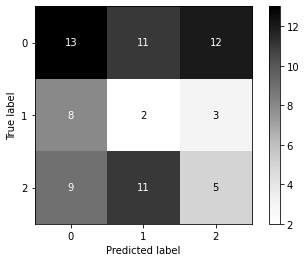

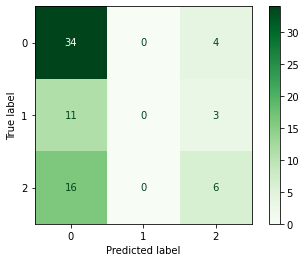

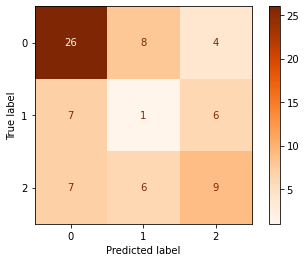

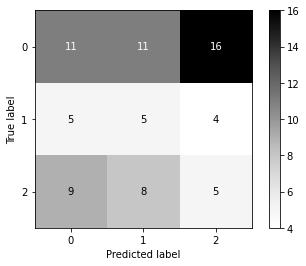

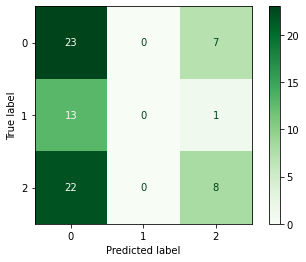

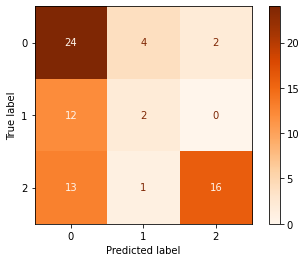

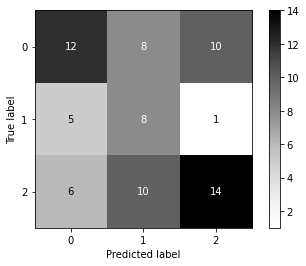

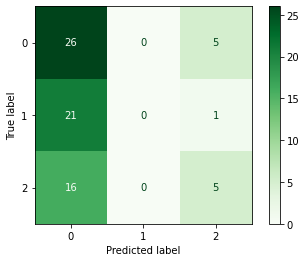

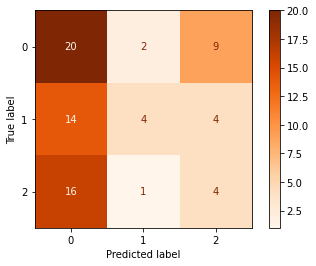

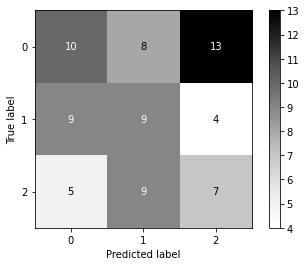

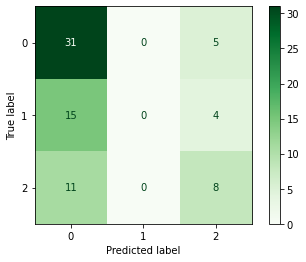

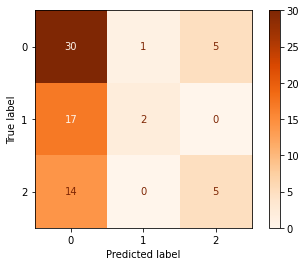

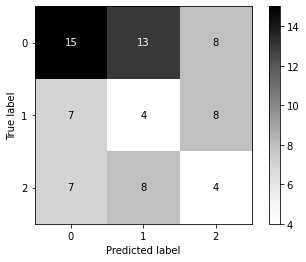

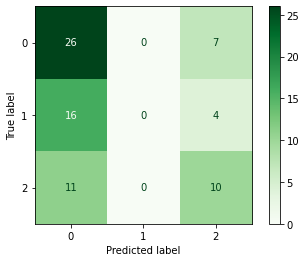

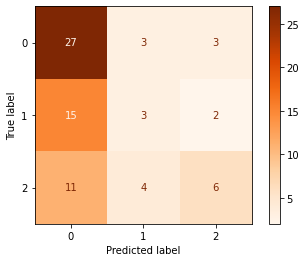

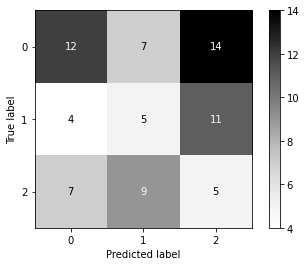

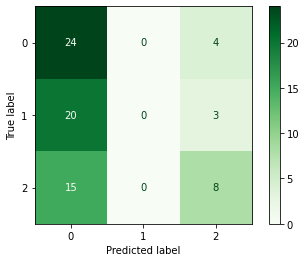

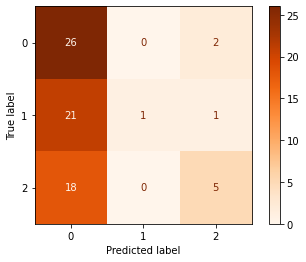

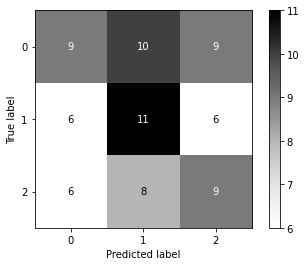

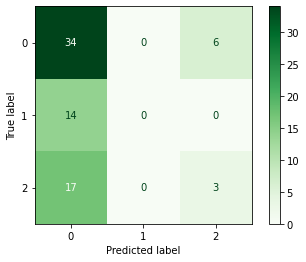

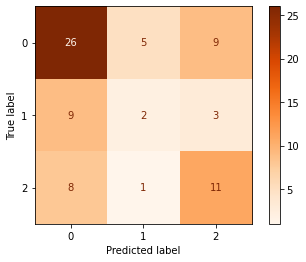

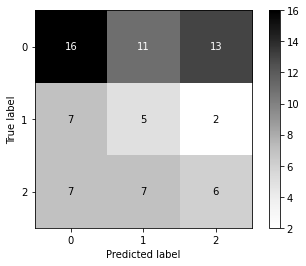

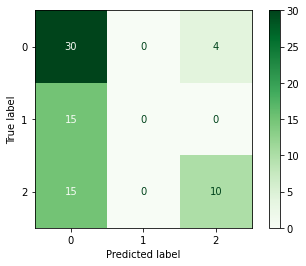

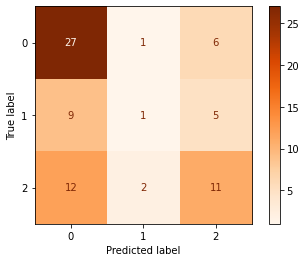

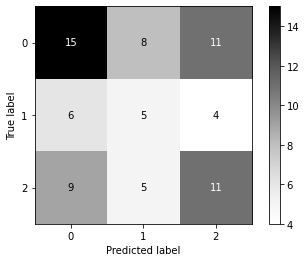

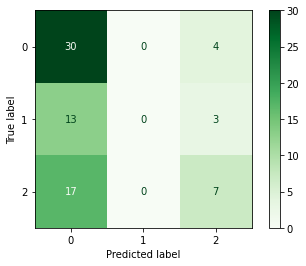

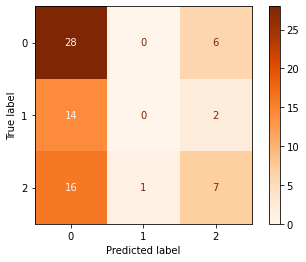

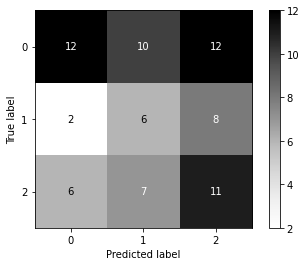

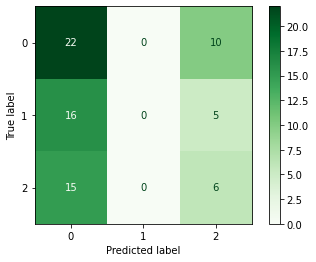

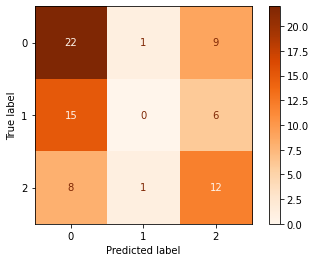

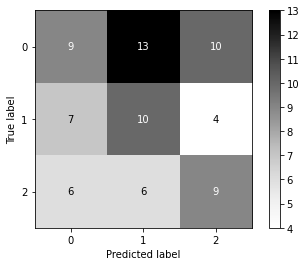

In [12]:
rand_result = []
bn_result = []
nn_result = []
count = 0
while count < 20:
    kf = KFold(5,shuffle=True)
    fold = 0
    nn_accuracies = []
    rand_accuracies = []
    bn_accuracies = []
    for train_index, test_index in kf.split(np_data):
        fold+=1
        train_scores, test_scores = np_scores[train_index], np_scores[test_index]
        train_data, test_data = np_data[train_index], np_data[test_index]
        train_labels, test_labels = np_labels[train_index], np_labels[test_index]
        b_network = build_baysian(train_data, train_scores, train_labels)
        model = build_model(train_data,train_labels)

        bn_accuracies.append(evaluate_baysian(b_network ,test_data, test_labels))
        nn_accuracies.append(evaluate_model(model, test_data, test_labels))
        rand_accuracies.append(random_guess(test_labels))

    rand_avg = mean(rand_accuracies)
    nn_avg = mean(nn_accuracies)
    bn_avg = mean(bn_accuracies)
    rand_result.append(rand_avg)
    bn_result.append(bn_avg)
    nn_result.append(nn_avg)
    count += 1
print("rand:")
print(mean(rand_result))
print(rand_result)
print("nn:")
print(mean(nn_result))
print(nn_result)
print("bn:")
print(mean(bn_result))
print(bn_result)

Outputs results and creates a box plot of results.

Random: [0.35135135, 0.2945946, 0.30810812, 0.3054054, 0.32162163, 0.3837838, 0.34324324, 0.33243242, 0.3108108, 0.34324324, 0.2918919, 0.31621623, 0.3081081, 0.27297297, 0.2891892, 0.36486486, 0.34864864, 0.3162162, 0.34054053, 0.38918918]
Neural Network: [0.4783784, 0.5081081, 0.48108107, 0.46216217, 0.4810811, 0.47567567, 0.48108107, 0.4783784, 0.4783784, 0.5081081, 0.4945946, 0.44864863, 0.4864865, 0.48378378, 0.45945945, 0.4864865, 0.47027028, 0.5, 0.48378378, 0.48378378]
Bayesian Network: [0.45675677, 0.47297296, 0.46216217, 0.44864863, 0.46486488, 0.45675674, 0.47027028, 0.47027028, 0.46216217, 0.48108107, 0.46756756, 0.48378378, 0.46486488, 0.45675674, 0.46756756, 0.4783784, 0.47567567, 0.45135134, 0.47837836, 0.47027028]


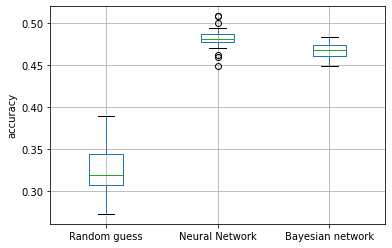

In [18]:
data = []
for i in range(len(rand_result)):
    data.append((rand_result[i],nn_result[i],bn_result[i]))
data = np.array(data)
df = pd.DataFrame(data,
                  columns=['Random guess','Neural Network','Bayesian network'])

boxplot = df.boxplot(column=['Random guess','Neural Network','Bayesian network'])
boxplot.set_ylabel("accuracy")
print("Random: " +str(rand_result))
print("Neural Network: " +str(nn_result))
print("Bayesian Network: " +str(bn_result))

Conducts and outputs a Wilcoxon Rank Sum Test to compare each set of results against eachother.

In [14]:
print(wilcoxon(bn_result,rand_result,alternative = "greater"))
print(wilcoxon(nn_result,rand_result,alternative = "greater"))
print(wilcoxon(nn_result,bn_result,alternative = "greater"))

[0.35135135, 0.2945946, 0.30810812, 0.3054054, 0.32162163, 0.3837838, 0.34324324, 0.33243242, 0.3108108, 0.34324324, 0.2918919, 0.31621623, 0.3081081, 0.27297297, 0.2891892, 0.36486486, 0.34864864, 0.3162162, 0.34054053, 0.38918918]
[0.4783784, 0.5081081, 0.48108107, 0.46216217, 0.4810811, 0.47567567, 0.48108107, 0.4783784, 0.4783784, 0.5081081, 0.4945946, 0.44864863, 0.4864865, 0.48378378, 0.45945945, 0.4864865, 0.47027028, 0.5, 0.48378378, 0.48378378]
[0.45675677, 0.47297296, 0.46216217, 0.44864863, 0.46486488, 0.45675674, 0.47027028, 0.47027028, 0.46216217, 0.48108107, 0.46756756, 0.48378378, 0.46486488, 0.45675674, 0.46756756, 0.4783784, 0.47567567, 0.45135134, 0.47837836, 0.47027028]
WilcoxonResult(statistic=210.0, pvalue=9.5367431640625e-07)
WilcoxonResult(statistic=210.0, pvalue=9.5367431640625e-07)
WilcoxonResult(statistic=186.0, pvalue=0.0007162094116210938)


Conducts some simple analysis of the data set, determines the distrubution of labels in this season and outputs.

(0.4540540540540541, 0.24054054054054055, 0.3054054054054054)


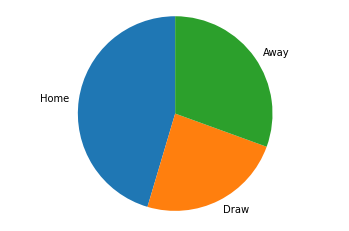

In [15]:
countH = 0
countD = 0
countA = 0
total = 0
for i in range(len(np_labels)):
    if np_labels[i] == 0:
        countH+=1
    elif np_labels[i] == 1:
        countD+=1
    elif np_labels[i] == 2:
        countA+=1
    total += 1
Hrate = countH/total
Drate = countD/total
Arate = countA/total
print(str((Hrate, Drate, Arate)))
labels = 'Home', 'Draw', 'Away'
sizes = [Hrate, Drate, Arate]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, startangle=90)
ax1.axis('equal') 

plt.show()